In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import xgboost
from xgboost import XGBClassifier
import joblib
import seaborn as sns
import pickle
from importlib import reload
import csv

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions

print ('Success')


Welcome to JupyROOT 6.24/06
Success


## Reading in files

In [3]:
Params = {"Run":"run1", #The run number, so far either "run1" or "run3"
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":10,
          "Load_standard":True, #bkgs
          "Load_lepton_signal":False,
          "Load_pi0_signal":True,
          "Load_DetVars":False, #This is for overlay
          "Only_keep_common_DetVar_evs":True,
          "Load_Signal_DetVars":False, #Don't do here, but in seperate script
          "Load_data":False,
          "FLATTEN":True, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":False, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "EXT_in_training":False,
          "Use_logit":True,
          "nbins":5} 

feature_names = Variables.First_pass_vars_for_BDT #All variables
feature_names_MC = feature_names + ["weight"]
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/my_vars/"

samples = Functions.create_test_samples_list(Params)

if Params["Load_pi0_signal"] == True:
    pi0_sample_strings = [] #Unfortunately need to make, to discriminate lepton final states from pi0 final states for signal
    for pi0_point in Constants.HNL_mass_pi0_samples:
        pi0_sample_strings += [str(pi0_point)+"_pi0"]

Loading these run1 samples: 
['overlay', 'dirtoverlay', 'beamoff', '150_pi0', '180_pi0', '200_pi0', '220_pi0', '240_pi0', '245_pi0']


In [5]:
sample_test_dict = {}
for sample in samples:
    if sample in Constants.Detector_variations: #Reading in an overlay DetVar sample
        loc=loc_pkls+"DetVars/"+"Preselected_overlay_"+Params["Run"]+"_my_vars"+f"_{sample}_flattened_reduced_evs.pkl"
        sample_test_dict[sample] = pd.read_pickle(loc)
    elif Params["Load_Signal_DetVars"] == True:
        loc=loc_pkls+"Signal_DetVars/"+"Preselected_"+Params["Run"]+f"_{sample}_reduced_evs_final.pkl"
        sample_test_dict[sample] = pd.read_pickle(loc)
    #elif sample in Constants.Signal_DetVars: #For signal DetVar samples, now doing in another script
    elif Params["Load_pi0_signal"] == True:
        if sample == 'overlay':
            # sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/pi0_selection/Test_overlay_"+Params["Run"]+"_FIXED.pkl")
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/pi0_selection/Test_overlay_"+Params["Run"]+".pkl")
        elif sample in pi0_sample_strings:
            # sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/pi0_selection/Test_signal_{sample}_"+Params["Run"]+"_FIXED.pkl")
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/pi0_selection/Test_signal_{sample}_"+Params["Run"]+".pkl")
        elif (sample == 'beamoff') and (Params["EXT_in_training"] == True): #EXT only if extra EXT has been added
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/pi0_selection/Test_beamoff_"+Params["Run"]+".pkl")
        else: 
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"pi0_selection/Preselected_"+Params["Run"]+f"_{sample}.pkl")
    else: #Standard sample types
        if sample == 'overlay':
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/Test_overlay_"+Params["Run"]+"_my_vars_flattened_FIXED.pkl")
        elif (Params["Load_single_file"] == True) and (isinstance(sample,int)):
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/Test_signal_{sample}_"+Params["Run"]+"_my_vars_flattened_FIXED.pkl")
        elif sample in Constants.HNL_mass_samples:
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/Test_signal_{sample}_"+Params["Run"]+"_my_vars_flattened_FIXED.pkl")
        elif (sample == 'beamoff') and (Params["EXT_in_training"] == True): #EXT only if extra EXT has been added
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/Test_beamoff_"+Params["Run"]+"_my_vars_flattened.pkl")
        else: 
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+"_my_vars_flattened_New_gen.pkl")


In [8]:
New_feature_list = ['shrclusdir2', 'n_tracks', 'trk_energy', 'shr_theta_v', 'contained_sps_ratio', 'trk_chipr_best', 'shr_px_v',
                    'trk_end_x_v', 'n_pfps', 'pfnplanehits_V', 'pfnplanehits_U', 'trk_calo_energy_u_v', 'nu_flashmatch_score', 'trk_score_v',
                    'NeutrinoEnergy2', 'shr_phi_v', 'pfnplanehits_Y', 'shr_pz_v', 'trk_theta_v', 'trk_phi_v', 'trk_energy_hits_tot',
                    'trk_dir_z_v', 'SliceCaloEnergy2']

bdt_vars = feature_names
# bdt_vars = New_feature_list
xgb_test_dict = {}
for sample in sample_test_dict:
    xgb_test_dict[sample] = xgboost.DMatrix(sample_test_dict[sample][bdt_vars])
    # print("Done " + str(sample))
    
if Params["Load_single_file"] == True:
    HNL_mass = Params["single_file"]
    bdt = xgboost.Booster()
    bdt.load_model(f"bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_My_variables_FIXED.json")
    for sample in xgb_test_dict:
        results = bdt.predict(xgb_test_dict[sample])
        sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
    
elif Params["Load_pi0_signal"] == False:
    for HNL_mass in Constants.HNL_mass_samples:
        bdt = xgboost.Booster()
        # bdt.load_model(f"bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_My_variables_flattened_highest_E_1.json")
        bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_New_20_variables_FIXED.json")
        for sample in xgb_test_dict:
            results = bdt.predict(xgb_test_dict[sample])
            sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
            
if Params["Load_pi0_signal"] == True:
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        bdt = xgboost.Booster()
        # bdt.load_model(f"bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}_MeV_pi0_FIXED.json")
        bdt.load_model(f"bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}_MeV_pi0.json")
        for sample in xgb_test_dict:
            results = bdt.predict(xgb_test_dict[sample])
            sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results

## Checking max BDT score (for logit transformation)

In [12]:
sample_test_dict["150_pi0"].keys()

Index(['run', 'sub', 'evt', 'shr_energy_tot', 'shr_energy', 'shr_theta_v',
       'shr_pca_0', 'shr_pca_1', 'shr_pca_2', 'shr_phi_v',
       ...
       'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y', 'highest_E',
       'BDT_output_150MeV', 'BDT_output_180MeV', 'BDT_output_200MeV',
       'BDT_output_220MeV', 'BDT_output_240MeV', 'BDT_output_245MeV'],
      dtype='object', length=125)

In [13]:
# HNL_mass = 2
# plt.hist(Functions.logit(sample_test_dict[HNL_mass][f"BDT_output_{HNL_mass}MeV"]))
# print(max(Functions.logit(sample_test_dict[HNL_mass][f"BDT_output_{HNL_mass}MeV"])))
# plt.hist(Functions.logit(sample_test_dict["overlay"][f"BDT_output_{HNL_mass}MeV"]))
# print(max(Functions.logit(sample_test_dict["overlay"][f"BDT_output_{HNL_mass}MeV"])))

if Params["Load_pi0_signal"] == False: HNL_masses = Constants.HNL_mass_samples
if Params["Load_pi0_signal"] == True: HNL_masses = Constants.HNL_mass_pi0_samples

max_scores = []
for HNL_mass in HNL_masses:
    if Params["Load_pi0_signal"] == False:
        max_scores.append(max(Functions.logit(sample_test_dict[HNL_mass][f"BDT_output_{HNL_mass}MeV"])))
    if Params["Load_pi0_signal"] == True:
        max_scores.append(max(Functions.logit(sample_test_dict[str(HNL_mass)+"_pi0"][f"BDT_output_{HNL_mass}MeV"])))
    
max_all_scores = max(max_scores)
print("Maximum score for all signal samples is " + str(max_all_scores))

max_score_int = np.ceil(max_all_scores)
print("Maximum integer for bins is " + str(max_score_int))

Maximum score for all signal samples is 5.765015125274658
Maximum integer for bins is 6.0


In [7]:
if Params["Load_Signal_DetVars"] == True: max_score_int = 7.0

## Saving BDT output for reweighting systematics plots

In [5]:
pkl_results_loc = "pkl_files/"+Params["Run"]+"/current_files/Results/"

# print(sample_test_dict['overlay'].keys())

print_vals = input("Do you want to save the new BDT scores to .pkl files? y/n ")
if print_vals == "y":
    
    columns = Variables.event_vars + Variables.weight_related + ["weight"]
    for HNL_mass in Constants.HNL_mass_samples:
        columns.append(f'BDT_output_{HNL_mass}MeV')
    print(columns)
    
    overlay_to_save = sample_test_dict['overlay'][columns].copy()

    #df2 = overlay_merged_to_save.loc[:,~overlay_merged_to_save.columns.duplicated()] #Getting rid of duplicate "weight" column
    #df2.to_pickle(pkl_results_loc + "overlay_results.pkl")
    overlay_to_save.to_pickle(pkl_results_loc + "overlay_results.pkl")
    
    print(overlay_to_save.keys())

Do you want to save the new BDT scores to .pkl files? y/n  y


['run', 'sub', 'evt', 'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'weight', 'BDT_output_2MeV', 'BDT_output_10MeV', 'BDT_output_20MeV', 'BDT_output_50MeV', 'BDT_output_100MeV', 'BDT_output_150MeV', 'BDT_output_180MeV', 'BDT_output_200MeV', 'BDT_output_220MeV', 'BDT_output_240MeV', 'BDT_output_245MeV']
Index(['run', 'sub', 'evt', 'weightSplineTimesTune', 'ppfx_cv', 'npi0',
       'weight', 'BDT_output_2MeV', 'BDT_output_10MeV', 'BDT_output_20MeV',
       'BDT_output_50MeV', 'BDT_output_100MeV', 'BDT_output_150MeV',
       'BDT_output_180MeV', 'BDT_output_200MeV', 'BDT_output_220MeV',
       'BDT_output_240MeV', 'BDT_output_245MeV'],
      dtype='object')


## Saving only high BDT Score events for variable study

In [8]:
cutoff = 0.95
signal_like = {}
frac_retained = {}
pkl_variable_tests_loc = "pkl_files/"+Params["Run"]+"/current_files/Variable_tests/"

Number_signal = 1000
top_signal = {}

for HNL_mass in Constants.HNL_mass_samples:
    signal_like[HNL_mass] = sample_test_dict[HNL_mass].query(f"BDT_output_{HNL_mass}MeV > {cutoff}")
    frac_retained[HNL_mass] = len(signal_like[HNL_mass])/len(sample_test_dict[HNL_mass])
    
    signal_like[HNL_mass].to_pickle(pkl_variable_tests_loc + f"signal_like_{HNL_mass}_MeV.pkl")
    
    top_signal[HNL_mass] = sample_test_dict[HNL_mass].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(Number_signal)
    
print(frac_retained)


{20: 0.599705304518664, 50: 0.5728995057660626, 100: 0.46100065545116886, 150: 0.47742831630122035, 180: 0.31082020389249304, 200: 0.22048054919908466}


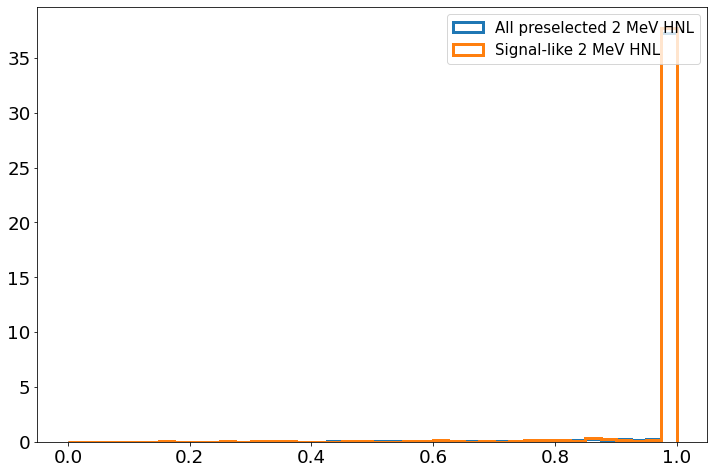

In [54]:
plt.figure(figsize=[12,8],facecolor='white')

HNL_mass = 2

variable = 'contained_sps_ratio'

bins = 40
xlims = [0,1.0]

plt.hist(sample_test_dict[HNL_mass][variable],
#               label=[f"HNL ({mass} MeV) \n $|U_{{\mu4}}|^2="+sci_notation(sample_info["300"]["theta_u2"]) +f" (x{HNLplotscale})"],
         label=[f"All preselected {HNL_mass} MeV HNL"],
         range=xlims,bins=bins,
         stacked=False,density=True,
         histtype="step",lw=3)

plt.hist(top_signal[HNL_mass][variable],
#               label=[f"HNL ({mass} MeV) \n $|U_{{\mu4}}|^2="+sci_notation(sample_info["300"]["theta_u2"]) +f" (x{HNLplotscale})"],
         label=[f"Signal-like {HNL_mass} MeV HNL"],
         range=xlims,bins=bins,
         stacked=False,density=True,
         histtype="step",lw=3)
plt.legend()

## Make list of run subrun event which are most signal-like

In [9]:
sample_CV_100 = sample_test_dict['100_CV']

In [12]:
top_N = 50
csv_location = "bdt_output/signal_like_rse_lists/CV_samples/"
HNL_mass = 100
# for HNL_mass in Constants.HNL_mass_samples:
signal_sorted = sample_CV_100.sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
signal_run_sub_event = signal_sorted[["run", "sub", "evt"]]
csv_name = csv_location + Params["Run"] + f"_signal_CV_{HNL_mass}.csv"
signal_run_sub_event.to_csv(csv_name, sep=" ", header=False, index=False)

txt_file = csv_location + Params["Run"] + f"_signal_CV_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
with open(txt_file, "w") as my_output_file:
    with open(csv_name, "r") as my_input_file:
        [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

In [17]:
sample_test_dict['100_CV']["evt"].head()

entry  subentry
1      0           77702
5      2           77706
8      0           77709
14     0           77715
15     0           77716
Name: evt, dtype: int32

In [6]:
top_N = 50
csv_location = "bdt_output/signal_like_rse_lists/"
for HNL_mass in Constants.HNL_mass_samples:
    signal_sorted = sample_test_dict[HNL_mass].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
    overlay_sorted = sample_test_dict['overlay'].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
    dirt_sorted = sample_test_dict['dirtoverlay'].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
    beamoff_sorted = sample_test_dict['beamoff'].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
    signal_run_sub_event = signal_sorted[["run", "sub", "evt"]]
    overlay_run_sub_event = overlay_sorted[["run", "sub", "evt"]]
    dirt_run_sub_event = dirt_sorted[["run", "sub", "evt"]]
    beamoff_run_sub_event = beamoff_sorted[["run", "sub", "evt"]]
    # print(df_run_sub_event.keys())
    csv_name = csv_location + Params["Run"] + f"_signal_{HNL_mass}.csv"
    csv_overlay_name = csv_location + Params["Run"] + f"_overlay_{HNL_mass}.csv"
    csv_dirt_name = csv_location + Params["Run"] + f"_dirtoverlay_{HNL_mass}.csv"
    csv_beamoff_name = csv_location + Params["Run"] + f"_beamoff_{HNL_mass}.csv"

    signal_run_sub_event.to_csv(csv_name, sep=" ", header=False, index=False) #i.e separating by a space, removing column names
    overlay_run_sub_event.to_csv(csv_overlay_name, sep=" ", header=False, index=False)
    dirt_run_sub_event.to_csv(csv_dirt_name, sep=" ", header=False, index=False)
    beamoff_run_sub_event.to_csv(csv_beamoff_name, sep=" ", header=False, index=False)
    
    #signal
    csv_file = csv_name
    txt_file = csv_location + Params["Run"] + f"_signal_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()
        
    #overlay
    csv_file = csv_overlay_name
    txt_file = csv_location + Params["Run"] + f"_overlay_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()
        
    #dirt
    csv_file = csv_dirt_name
    txt_file = csv_location + Params["Run"] + f"_dirtoverlay_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()
        
    #beamoff
    csv_file = csv_beamoff_name
    txt_file = csv_location + Params["Run"] + f"_beamoff_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()

## Calculating efficiency

In [30]:
def calculate_efficiency(df, file_name, Run, BDT_cutoff, HNL_mass, debug=False):
    if Run == "run1": ev_num_dict = Constants.run1_event_numbers
    if Run == "run3": ev_num_dict = Constants.run3_event_numbers
    
    if file_name == "beamoff" or file_name == "dirtoverlay":
        norm = 1.0
    else:
        train_vs_test_fraction = 0.7 #Set in script 3.0
        norm = 1.0/(1-train_vs_test_fraction) #Need to scale up to account for events lost
    
    total_ev_num = len(df)
    ev_num_initial = ev_num_dict[file_name]
    cut_df = df.query(f"BDT_output_{HNL_mass}MeV > {BDT_cutoff}")
    new_ev_num = len(cut_df)
    
    efficiency = norm*(new_ev_num/ev_num_initial)
    
    if debug:
        print(f"Total events is {total_ev_num}")
        print(f"Events after cut is {new_ev_num}")
    
    return efficiency

def sum_total_weights(df): #This is to check that the weighting doesn't affect the overall efficiency significantly (i.e av weight is approx 1)
    total_evs = len(df)
    sum_weights = df["weight"].sum()
    
    weight_per_ev = sum_weights/total_evs
    
    print(f"Sum of weights is {sum_weights}")
    print(f"Average weight is {weight_per_ev}")

In [31]:
print(sample_test_dict.keys())

dict_keys(['overlay', 'dirtoverlay', 'beamoff', 2, 10, 20, 50, 100, 150, 180, 200, 220, 240, 245])


In [32]:
logit_BDT_cut = -20
# logit_BDT_cut = 2.0
standard_BDT_cut = Functions.invlogit(logit_BDT_cut)
print(f"Using a logit BDT cut of {logit_BDT_cut}, which corresponds to {standard_BDT_cut} in [0,1] BDT score.")

efficiency_dict = {}

for file in Constants.HNL_mass_samples: #Just signal samples
# for file in sample_test_dict:

    efficiency_dict[file] = calculate_efficiency(sample_test_dict[file], file, Params["Run"], standard_BDT_cut, file, debug=False)


Using a logit BDT cut of -20, which corresponds to 2.0611536181902033e-09 in [0,1] BDT score.


In [33]:
for file in ['overlay', 'dirtoverlay', 'beamoff']: #Calculating efficiency for 100MeV BDT model score

    efficiency_dict[file] = calculate_efficiency(sample_test_dict[file], file, Params["Run"], standard_BDT_cut, 100, debug=True)

Total events is 9348
Events after cut is 9348
Total events is 3345
Events after cut is 3345
Total events is 13067
Events after cut is 13067


In [34]:
print(Params["Run"] + " pre-selectoin efficiencies are")
for file in sample_test_dict:
    # print(f"{file} efficiency is " + str(efficiency_dict[file]))
    print(f"{file} efficiency is " + str(efficiency_dict[file]*100) + " %")

overlay efficiency is 4.1618694754388255 %
dirtoverlay efficiency is 0.8593139874224177 %
beamoff efficiency is 0.40693258409820693 %
2 efficiency is 41.734021272983604 %
10 efficiency is 36.37481351535733 %
20 efficiency is 37.85870525690612 %
50 efficiency is 36.025931492406734 %
100 efficiency is 36.030666902113126 %
150 efficiency is 39.607189179173616 %
180 efficiency is 36.77396932968417 %
200 efficiency is 36.22721448199749 %
220 efficiency is 24.479494355614374 %
240 efficiency is 25.57134583686016 %
245 efficiency is 25.95018143441616 %


## Plotting BDT outputs

In [14]:
#Needs to be rewritten, perhaps made into a function
train_vs_test_fraction = 0.7 #This was set in 3_BDT_training, need to change if I have changed this there.
SF_test = 1.0/(1-train_vs_test_fraction)
    
if Params["Run"] == "run1":
    overlay_scale = Constants.SF_overlay_run1*SF_test
    EXT_scale_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run1
    dirt_scale = Constants.SF_dirt_run1
        
elif Params["Run"] == "run3":
    overlay_scale = Constants.SF_overlay_run3*SF_test
    EXT_scale_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run3
    dirt_scale = Constants.SF_dirt_run3

print("Creating the sample and normalisation dictionaries")    
samples_plot={'overlay_test':sample_test_dict['overlay'],
         'dirtoverlay':sample_test_dict['dirtoverlay'],
         'beamoff':sample_test_dict['beamoff']}

sample_norms={'overlay_test':np.array(sample_test_dict['overlay']["weight"]*overlay_scale),
         'dirtoverlay':np.array(sample_test_dict['dirtoverlay']["weight"]*dirt_scale),
         'beamoff':EXT_scale_list}

print("Adding signal samples to sample plot dictionary")
if Params["Load_single_file"] == True:
    HNL_mass = Params["single_file"]
    signal_scale_list = np.ones(len(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV']))*SF_test
    samples_plot[HNL_mass]=sample_test_dict[HNL_mass]
    sample_norms[HNL_mass]=signal_scale_list
elif Params["Load_pi0_signal"] == False:
    for HNL_mass in Constants.HNL_mass_samples:
        signal_scale_list = np.ones(len(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV']))*SF_test
        samples_plot[HNL_mass]=sample_test_dict[HNL_mass]
        sample_norms[HNL_mass]=signal_scale_list
if Params["Load_pi0_signal"] == True:
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        signal_scale_list = np.ones(len(sample_test_dict[str(HNL_mass)+"_pi0"][f'BDT_output_{HNL_mass}MeV']))*SF_test
        samples_plot[HNL_mass]=sample_test_dict[str(HNL_mass)+"_pi0"]
        sample_norms[HNL_mass]=signal_scale_list

Creating the sample and normalisation dictionaries
Adding signal samples to sample plot dictionary


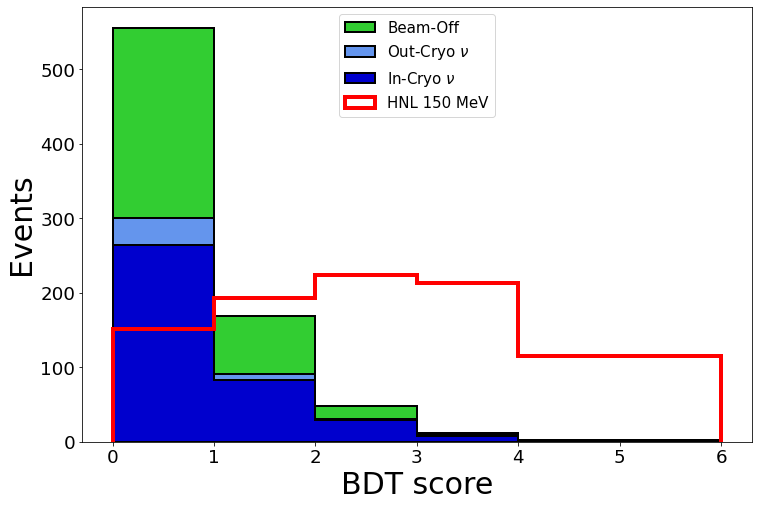

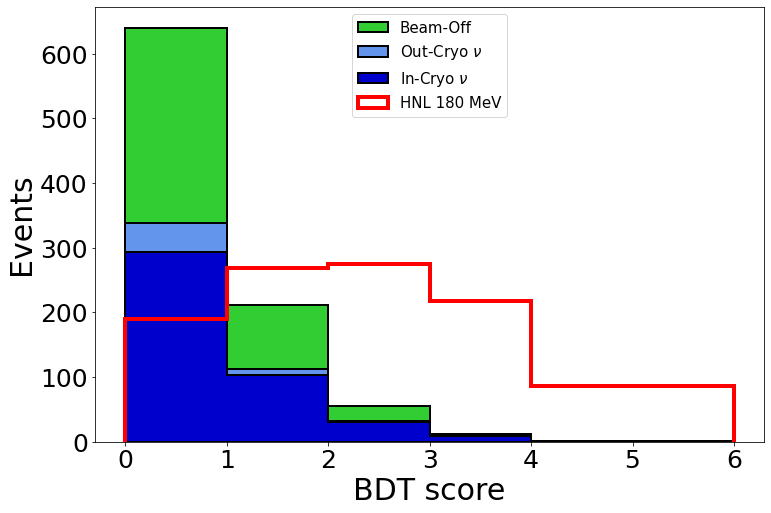

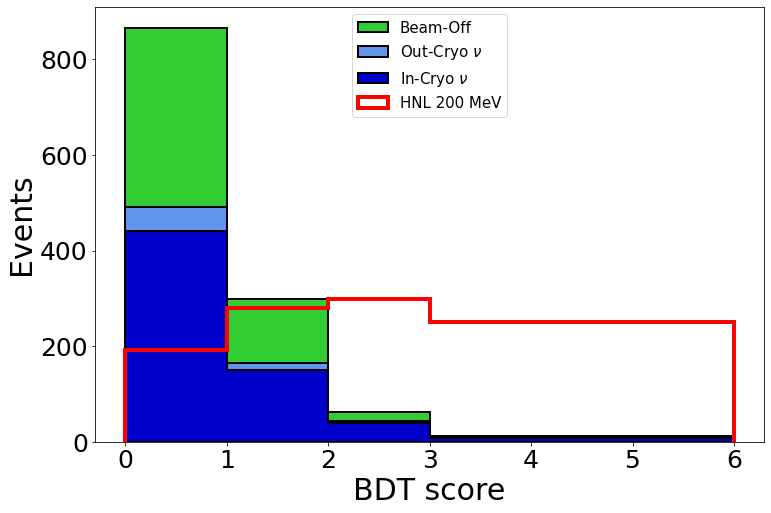

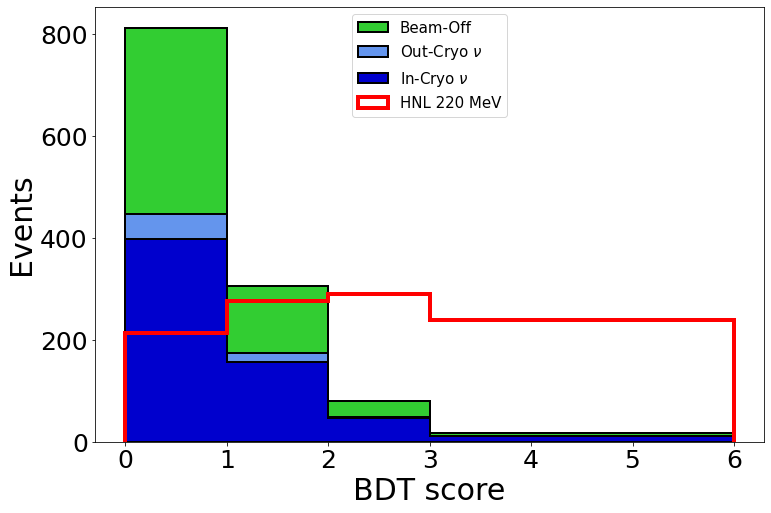

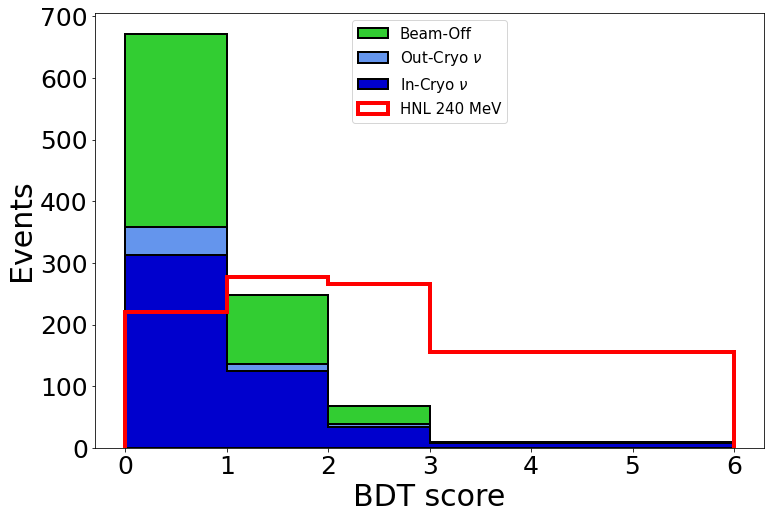

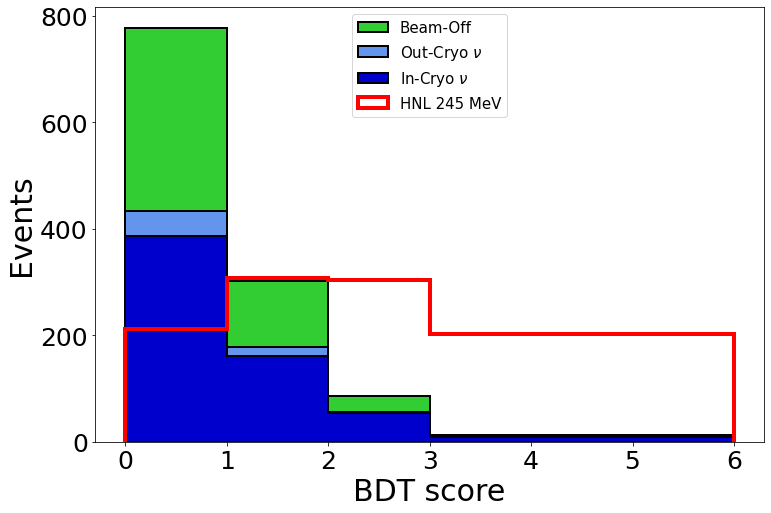

In [15]:
if Params["Load_single_file"] == True:
    HNL_masses = [Params["single_file"]]
elif Params["Load_pi0_signal"] == False:
    HNL_masses = Constants.HNL_mass_samples
if Params["Load_pi0_signal"] == True:
    HNL_masses = Constants.HNL_mass_pi0_samples
    

xlims=[0,max_score_int]    
BINS = int(xlims[1]-xlims[0])
    
PT.Plot_BDT_output(HNL_masses=HNL_masses, samples=samples_plot, sample_norms=sample_norms, colours={}, xlims=xlims,
                   bins=BINS,figsize=[12,8], MergeBins=True, density=False, legloc="upper center",logy=False, savefig=False, 
                   save_str = "top_20_test_New_gen", Run=Params["Run"], logit = Params["Use_logit"], HNL_scale=0.04)

#If plotting data too:
# PT.Plot_BDT_output(HNL_masses=HNL_masses, samples=samples_plot, sample_norms=sample_norms, colours={}, xlims=xlims,
#                    bins=BINS,figsize=[12,8], MergeBins=True, density=False, legloc="upper center",logy=False, savefig=False, 
#                    save_str = "top_20_test_New_gen", Run=Params["Run"], logit = Params["Use_logit"], HNL_scale=0.04)

## Saving output to .root files

In [8]:
#Checking which bins to merge Need to properly write this
nbins_dict = {}
xlims = [0,max_score_int]
nbins = Params["nbins"]*2
#Need to logit samples

for HNL_mass in Constants.HNL_mass_samples:
    bins_list = np.histogram(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV'],bins=Params["nbins"],range=xlims)[1] #For mergebins part
    if Params["Use_logit"] == True:
        bkg_scores=[Functions.logit(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV']),
                    Functions.logit(sample_test_dict['dirtoverlay'][f'BDT_output_{HNL_mass}MeV']),
                    Functions.logit(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV'])]
    totbkg=np.histogram(bkg_scores[0],bins=Params["nbins"],range=xlims)[0]+np.histogram(bkg_scores[1],bins=Params["nbins"],range=xlims)[0]+np.histogram(bkg_scores[2],bins=Params["nbins"],range=xlims)[0]
    offbkg=np.histogram(bkg_scores[2],bins=Params["nbins"],range=xlims)[0]
    overlaybkg=np.histogram(bkg_scores[0],bins=Params["nbins"],range=xlims)[0]
    dirtbkg=np.histogram(bkg_scores[1],bins=Params["nbins"],range=xlims)[0]
    bins_new=[]
    for i,bin_bkg in enumerate(totbkg):
        if(offbkg[i]>1 or overlaybkg[i]>1):
            bins_new.append(bins_list[i])

    bins_new.append(bins_list[-1])
    nbins_dict[HNL_mass] = bins_new
    
HNL_mass = 240 

overlay_bdt_hist = np.histogram(Functions.logit(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV']), 
                                        bins=nbins_dict[HNL_mass], weights=sample_norms['overlay_test'], range = xlims)[0]
print(overlay_bdt_hist)
    
print(nbins_dict)  
print(len(nbins_dict[HNL_mass]))
rfile = ROOT.TFile(f'bdt_output/Test_varbins.root','RECREATE')
tData = ROOT.TH1F(str(HNL_mass),str(HNL_mass),len(nbins_dict[HNL_mass])-1,array("d",nbins_dict[HNL_mass]))
for i in range(len(nbins_dict[HNL_mass])-1):
    # print(i)
    # print(overlay_bdt_hist[i])
    tData.SetBinContent(i+1,overlay_bdt_hist[i])

    # tData.SetBinError(i+1,overlay_bdt_hist['err'][i])

rfile.Write()
rfile.Close()

[543.8906    320.6914    145.86914    40.51367     1.5136719]
{2: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0], 10: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0], 20: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0], 50: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0], 100: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0], 150: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0], 180: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0], 200: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0], 220: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0], 240: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0], 245: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]}
6
0
543.8906
1
320.6914
2
145.86914
3
40.51367
4
1.5136719


In [11]:
def Save_one_hist(hist,name,nbins,xlims):
    # tData = ROOT.TH1F(name,name,nbins,xlims[0],xlims[1])
    tData = ROOT.TH1F(name,name,len(nbins)-1,array("d",nbins))
    for i in range(len(nbins)-1):
        tData.SetBinContent(i+1,hist['hist'][i])
        tData.SetBinError(i+1,hist['err'][i])
    return tData
    
def SaveToRoot_new(nbins,xlims,hist_samples,fileName='test.root'): 
    rFile = ROOT.TFile(f'{fileName}','RECREATE')
    for name in hist_samples:
        tData = Save_one_hist(hist_samples[name],name,nbins,xlims)
        rFile.Write()
    #rFile.Write()
    rFile.Close()

def make_stat_err(hist, SF):
    stat_err = []
    for i in range(0,len(hist[0])):
        error = np.sqrt(hist[0][i])*np.sqrt(SF)
        stat_err.append(error)
    return stat_err

In [12]:
print(sample_test_dict.keys())

dict_keys(['overlay', 'dirtoverlay', 'beamoff', 2, 10, 20, 50, 100, 150, 180, 200, 220, 240, 245])


In [13]:
# original_theta = Constants.theta_mu_4
# original_theta = Constants.theta_mu_4_dict[HNL_mass]

SCALE_UP_dict = {2:5,10:5,20:200,50:50,100:10,150:5,180:4,200:2,220:2,240:2,245:2} #Doing this because the scale factor used in pyhf is bounded

new_theta_dict = {}

train_vs_test_fraction = 0.7 #This was set in 3_BDT_training, need to change if I have changed this there.
SF_test = 1.0/(1-train_vs_test_fraction)

MergeBins = True
nbins = Params["nbins"]*2
print(nbins)
if Params["Load_pi0_signal"] == False:
    # for HNL_mass in Constants.HNL_mass_samples:
    for HNL_mass in HNL_masses:
        original_theta = Constants.theta_mu_4_dict[HNL_mass]
        new_theta_dict[HNL_mass] = original_theta*SCALE_UP_dict[HNL_mass]
        SCALE_EVENTS = SCALE_UP_dict[HNL_mass]**4 #The Number of events is proportional to theta^4

        if Params["Run"] == "run1":
            SF_signal_list = np.ones(len(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV']))*Constants.run1_POT_scaling_dict[HNL_mass]*SF_test*SCALE_EVENTS
            SF_overlay_list = sample_test_dict['overlay']['weight']*Constants.SF_overlay_run1*SF_test
            SF_dirt_list = sample_test_dict['dirtoverlay']['weight']*Constants.SF_dirt_run1
            SF_EXT_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run1
        if Params["Run"] == "run3":
            SF_signal_list = np.ones(len(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV']))*Constants.run3_POT_scaling_dict[HNL_mass]*SF_test*SCALE_EVENTS
            SF_overlay_list = sample_test_dict['overlay']['weight']*Constants.SF_overlay_run3*SF_test
            SF_dirt_list = sample_test_dict['dirtoverlay']['weight']*Constants.SF_dirt_run3
            SF_EXT_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run3

        if Params["Use_logit"] == False:
            xlims_standard = (0.0,1.0)
            xlims = [0.0,1.0]
            signal_bdt_hist = np.histogram(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV'], 
                                       bins=nbins, weights=SF_signal_list, range = xlims_standard)
            overlay_bdt_hist = np.histogram(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV'], 
                                        bins=nbins, weights=SF_overlay_list, range = xlims_standard)
            dirt_bdt_hist = np.histogram(sample_test_dict['dirtoverlay'][f'BDT_output_{HNL_mass}MeV'], 
                                     bins=nbins, weights=SF_dirt_list, range = xlims_standard)
            EXT_bdt_hist = np.histogram(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV'], 
                                    bins=nbins, weights=SF_EXT_list, range = xlims_standard)
        if Params["Use_logit"] == True:
            xlims_logit = (-5.0,max_score_int)
            # nbins_new = int(max(xlims_logit) - min(xlims_logit))
            xlims = [-5.0,max_score_int] #This could be changed to [0,1.0] and root would just rescale the axis, could be useful to do this. 
            nbins_new = int(max(xlims) - min(xlims))
            
            bins_list = np.histogram(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV'],bins=nbins_new,range=xlims)[1] #For mergebins part
              
            if(MergeBins): #remove bins with zero bkg prediction
                totbkg=np.histogram(Functions.logit(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV']),bins=nbins_new,range=xlims)[0]+np.histogram(Functions.logit(sample_test_dict['dirtoverlay'][f'BDT_output_{HNL_mass}MeV']),bins=nbins_new,range=xlims)[0]+np.histogram(Functions.logit(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']),bins=nbins_new,range=xlims)[0]
                offbkg=np.histogram(Functions.logit(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']),bins=nbins_new,range=xlims)[0]
                overlaybkg=np.histogram(Functions.logit(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV']),bins=nbins_new,range=xlims)[0]
                dirtbkg=np.histogram(Functions.logit(sample_test_dict['dirtoverlay'][f'BDT_output_{HNL_mass}MeV']),bins=nbins_new,range=xlims)[0]
                bins_new=[]
                for i,bin_bkg in enumerate(totbkg):
                    if(offbkg[i]>1 or overlaybkg[i]>1):
                        bins_new.append(bins_list[i])

                bins_new.append(bins_list[-1])

                bins=bins_new
            else:
                bins=nbins_new
            signal_bdt_hist = np.histogram(Functions.logit(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV']), 
                                       bins=bins, weights=SF_signal_list, range = xlims_logit)
            overlay_bdt_hist = np.histogram(Functions.logit(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV']), 
                                        bins=bins, weights=SF_overlay_list, range = xlims_logit)
            dirt_bdt_hist = np.histogram(Functions.logit(sample_test_dict['dirtoverlay'][f'BDT_output_{HNL_mass}MeV']), 
                                     bins=bins, weights=SF_dirt_list, range = xlims_logit)
            EXT_bdt_hist = np.histogram(Functions.logit(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']), 
                                    bins=bins, weights=SF_EXT_list, range = xlims_logit)

        signal_bdt_err = make_stat_err(signal_bdt_hist, Constants.run1_POT_scaling_dict[HNL_mass]*SF_test*SCALE_EVENTS)
        overlay_bdt_err = make_stat_err(overlay_bdt_hist, Constants.SF_overlay_run1*SF_test)
        dirt_bdt_err = make_stat_err(dirt_bdt_hist, Constants.SF_dirt_run1)
        EXT_bdt_err = make_stat_err(EXT_bdt_hist, Constants.SF_EXT_run1)

        data_h = overlay_bdt_hist[0]+dirt_bdt_hist[0]+EXT_bdt_hist[0]

        bkg_overlay = {'bins': np.array(overlay_bdt_hist[1]), 'hist': np.array(overlay_bdt_hist[0]), 'err': np.array(overlay_bdt_err)}
        bkg_dirt = {'bins': np.array(dirt_bdt_hist[1]), 'hist': np.array(dirt_bdt_hist[0]), 'err': np.array(dirt_bdt_err)}
        bkg_EXT = {'bins': np.array(EXT_bdt_hist[1]), 'hist': np.array(EXT_bdt_hist[0]), 'err': np.array(EXT_bdt_err)}
        sig = {'bins': np.array(signal_bdt_hist[1]), 'hist': np.array(signal_bdt_hist[0]), 'err': np.array(signal_bdt_err)}
        data = {'bins': np.array(overlay_bdt_hist[1]), 'hist': np.array(data_h), 'err': np.array(overlay_bdt_err)}

        hist_samples = {"bkg_overlay":bkg_overlay,"bkg_dirt":bkg_dirt,"bkg_EXT":bkg_EXT,"signal":sig,"data":data}

        if Params["Use_logit"] == False:
            save_name = Params["Run"]+f"_{HNL_mass}MeV_test_top_20_FIXED.root"
        if Params["Use_logit"] == True:
            save_name = Params["Run"]+f"_{HNL_mass}MeV_logit_top_20_merged_FIXED.root"
        
        SaveToRoot_new(bins_new,xlims,hist_samples,fileName="bdt_output/"+save_name)
        SaveToRoot_new(bins_new,xlims,hist_samples,fileName="Uncertainties/"+save_name)

    # with open('bdt_output/new_theta_dict_2.pkl', 'wb') as handle: #Saving the scaled thetas dictionary
    with open('bdt_output/new_theta_dict.pkl', 'wb') as handle: #Saving the scaled thetas dictionary
        pickle.dump(new_theta_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(new_theta_dict)

10
{2: 0.5, 10: 0.05, 20: 0.02, 50: 0.005, 100: 0.001, 150: 0.0005, 180: 0.0004, 200: 0.0002, 220: 0.0002, 240: 0.0002, 245: 0.0002}


12.0
<class 'numpy.float64'>


In [13]:
original_theta = Constants.theta_mu_4
nbins_dict = {}
xlims = [0,5.0]
nbins = Params["nbins"]*2

SCALE_UP_pi0_dict = {150:10.0, 180:5, 200:2, 220:2, 240:1.0, 245:1.0} 

new_theta_dict = {}

train_vs_test_fraction = 0.7 #This was set in 3_BDT_training, need to change if I have changed this there.
SF_test = 1.0/(1-train_vs_test_fraction)

MergeBins = True
nbins = Params["nbins"]*2
print(nbins)

if Params["Load_pi0_signal"] == True:
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        new_theta_dict[HNL_mass] = original_theta*SCALE_UP_pi0_dict[HNL_mass]
        SCALE_EVENTS = SCALE_UP_pi0_dict[HNL_mass]**4 #The Number of events is proportional to theta^4

        if Params["Run"] == "run1":
            SF_signal_list = np.ones(len(sample_test_dict[str(HNL_mass)+"_pi0"][f'BDT_output_{HNL_mass}MeV']))*Constants.run1_POT_scaling_dict[str(HNL_mass)+"_pi0"]*SF_test*SCALE_EVENTS
            SF_overlay_list = sample_test_dict['overlay']['weight']*Constants.SF_overlay_run1*SF_test
            SF_dirt_list = sample_test_dict['dirtoverlay']['weight']*Constants.SF_dirt_run1
            SF_EXT_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run1
        if Params["Run"] == "run3":
            SF_signal_list = np.ones(len(sample_test_dict[str(HNL_mass)+"_pi0"][f'BDT_output_{HNL_mass}MeV']))*Constants.run3_POT_scaling_dict[str(HNL_mass)+"_pi0"]*SF_test*SCALE_EVENTS
            SF_overlay_list = sample_test_dict['overlay']['weight']*Constants.SF_overlay_run3*SF_test
            SF_dirt_list = sample_test_dict['dirtoverlay']['weight']*Constants.SF_dirt_run3
            SF_EXT_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run3

        if Params["Use_logit"] == False:
            xlims_standard = (0.0,1.0)
            xlims = [0.0,1.0]
            signal_bdt_hist = np.histogram(sample_test_dict[str(HNL_mass)+"_pi0"][f'BDT_output_{HNL_mass}MeV'], 
                                       bins=nbins, weights=SF_signal_list, range = xlims_standard)
            overlay_bdt_hist = np.histogram(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV'], 
                                        bins=nbins, weights=SF_overlay_list, range = xlims_standard)
            dirt_bdt_hist = np.histogram(sample_test_dict['dirtoverlay'][f'BDT_output_{HNL_mass}MeV'], 
                                     bins=nbins, weights=SF_dirt_list, range = xlims_standard)
            EXT_bdt_hist = np.histogram(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV'], 
                                    bins=nbins, weights=SF_EXT_list, range = xlims_standard)
        if Params["Use_logit"] == True:
            xlims_logit = (-5.0,5.0)
            xlims = [-5.0,5.0] #This could be changed to [0,1.0] and root would just rescale the axis, could be useful to do this. 
            bins_list = np.histogram(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV'],bins=nbins,range=xlims)[1] #For mergebins part
             
            if(MergeBins): #remove bins with zero bkg prediction
                totbkg=np.histogram(Functions.logit(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV']),bins=nbins,range=xlims)[0]+np.histogram(Functions.logit(sample_test_dict['dirtoverlay'][f'BDT_output_{HNL_mass}MeV']),bins=nbins,range=xlims)[0]+np.histogram(Functions.logit(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']),bins=nbins,range=xlims)[0]
                offbkg=np.histogram(Functions.logit(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']),bins=nbins,range=xlims)[0]
                overlaybkg=np.histogram(Functions.logit(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV']),bins=nbins,range=xlims)[0]
                dirtbkg=np.histogram(Functions.logit(sample_test_dict['dirtoverlay'][f'BDT_output_{HNL_mass}MeV']),bins=nbins,range=xlims)[0]
                bins_new=[]
                for i,bin_bkg in enumerate(totbkg):
                    if(offbkg[i]>1 or overlaybkg[i]>1):
                        bins_new.append(bins_list[i])

                bins_new.append(bins_list[-1])

                bins=bins_new
            else:
                bins=nbins
                
            signal_bdt_hist = np.histogram(Functions.logit(sample_test_dict[str(HNL_mass)+"_pi0"][f'BDT_output_{HNL_mass}MeV']), 
                                       bins=nbins, weights=SF_signal_list, range = xlims_logit)
            overlay_bdt_hist = np.histogram(Functions.logit(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV']), 
                                        bins=nbins, weights=SF_overlay_list, range = xlims_logit)
            dirt_bdt_hist = np.histogram(Functions.logit(sample_test_dict['dirtoverlay'][f'BDT_output_{HNL_mass}MeV']), 
                                     bins=nbins, weights=SF_dirt_list, range = xlims_logit)
            EXT_bdt_hist = np.histogram(Functions.logit(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']), 
                                    bins=nbins, weights=SF_EXT_list, range = xlims_logit)

        signal_bdt_err = make_stat_err(signal_bdt_hist, Constants.run1_POT_scaling_dict[str(HNL_mass)+"_pi0"]*SF_test*SCALE_EVENTS)
        overlay_bdt_err = make_stat_err(overlay_bdt_hist, Constants.SF_overlay_run1*SF_test)
        dirt_bdt_err = make_stat_err(dirt_bdt_hist, Constants.SF_dirt_run1)
        EXT_bdt_err = make_stat_err(EXT_bdt_hist, Constants.SF_EXT_run1)

        data_h = overlay_bdt_hist[0]+dirt_bdt_hist[0]+EXT_bdt_hist[0]

        bkg_overlay = {'bins': np.array(overlay_bdt_hist[1]), 'hist': np.array(overlay_bdt_hist[0]), 'err': np.array(overlay_bdt_err)}
        bkg_dirt = {'bins': np.array(dirt_bdt_hist[1]), 'hist': np.array(dirt_bdt_hist[0]), 'err': np.array(dirt_bdt_err)}
        bkg_EXT = {'bins': np.array(EXT_bdt_hist[1]), 'hist': np.array(EXT_bdt_hist[0]), 'err': np.array(EXT_bdt_err)}
        sig = {'bins': np.array(signal_bdt_hist[1]), 'hist': np.array(signal_bdt_hist[0]), 'err': np.array(signal_bdt_err)}
        data = {'bins': np.array(overlay_bdt_hist[1]), 'hist': np.array(data_h), 'err': np.array(overlay_bdt_err)}

        hist_samples = {"bkg_overlay":bkg_overlay,"bkg_dirt":bkg_dirt,"bkg_EXT":bkg_EXT,"signal":sig,"data":data}

        if Params["Use_logit"] == False:
            save_name = "pi0/"+Params["Run"]+f"_{HNL_mass}MeV_test1.root"
        if Params["Use_logit"] == True:
            save_name = "pi0/"+Params["Run"]+f"_{HNL_mass}MeV_logit_test1.root"

        SaveToRoot_new(bins_new,xlims,hist_samples,fileName=save_name)

    with open('bdt_output/pi0/new_theta_dict_pi0.pkl', 'wb') as handle: #Saving the scaled thetas dictionary
        pickle.dump(new_theta_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

10


## Plotting Detector Variations histograms (background)

In [77]:
if Params["Load_DetVars"] == True:
    if Params["Use_logit"] == False:
        max_y, bin_edges = np.histogram(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV'], weights=sample_test_dict["CV"]["weight"], 
                                    bins=Params["nbins"],range=[0,1.0])
    if Params["Use_logit"] == True:
        max_y, bin_edges = np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']), 
                                    weights=sample_test_dict["CV"]["weight"], bins=Params["nbins"],range=[-5.0,5.0])
    maxium = max(max_y)
    max_x = max(bin_edges)
    min_x = min(bin_edges)
    print(maxium)
    print(max_x)
    print(min_x)
    print("Max minus min is " + str(max_x - min_x))
#plt.ylim(0, maxium*1.3)

1558.1461
5.0
-5.0
Max minus min is 10.0


In [78]:
bins_dict = {}
for HNL_mass in Constants.HNL_mass_samples:
    hist_placeholder = uproot.open(f'bdt_output/'+Params["Run"]+f'_{HNL_mass}MeV_logit_top_20_merged.root')
    bins_dict[HNL_mass] = hist_placeholder['bkg_overlay'].to_numpy()[1] #A tuple of bin edges
print(bins_dict[240])

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  5.]


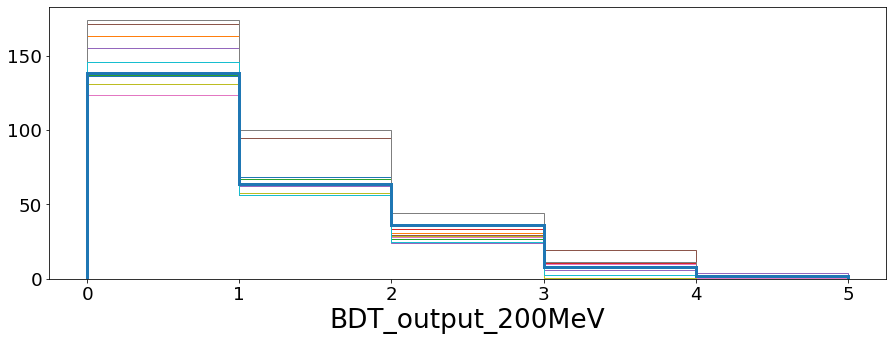

In [79]:
#Plotting the histograms for detector variations
HNL_mass = 200 # - Plot just one
if Params["Load_DetVars"] == True:
    for DetVar in Constants.Detector_variations:
        linewidth = 1
        if DetVar == "CV":
            linewidth = 3
        if Params["Use_logit"] == False:
            plt.hist(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV'], weights=sample_test_dict[DetVar]["weight"], 
                     bins=Params["nbins"],range=[0,1.0],label=f'{DetVar}',lw=linewidth,histtype="step")
        if Params["Use_logit"] == True:
            plt.hist(Functions.logit(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV']), weights=sample_test_dict[DetVar]["weight"], 
                     bins=5,range=[0.0,5.0],label=f'{DetVar}',lw=linewidth,histtype="step")
            
    plt.xlabel(f'BDT_output_{HNL_mass}MeV')
    #plt.legend()
    #plt.yscale("log")
    plt.yscale("linear")
    # plt.ylim(1, maxium*1.3)

In [80]:
def safe_div(x,y):
    if y == 0.0:
        return 0
    return x / y

In [81]:
HNL_mass = 10
DetVar = "LYAttenuation"
SF_overlay_list = weights=sample_test_dict["CV"]["weight"]
DetVar_SF_list = weights=sample_test_dict[DetVar]["weight"]

overlay_bdt_hist = np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']), 
                                bins=bins_dict[HNL_mass], weights=SF_overlay_list, 
                                range = [bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]])
overlay_no_weighting = np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']), 
                                bins=bins_dict[HNL_mass], 
                                range = [bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]])

DetVar_bdt_hist = np.histogram(Functions.logit(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV']), 
                                bins=bins_dict[HNL_mass], weights=DetVar_SF_list, 
                                range = [bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]])

DetVar_no_weighting = np.histogram(Functions.logit(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV']), 
                                bins=bins_dict[HNL_mass], 
                                range = [bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]])
overlay_bdt_err = make_stat_err(overlay_bdt_hist, 1.0)
print("CV unweighted:")
print(overlay_no_weighting[0])
print("CV weighted:")
print(overlay_bdt_hist[0])
print(overlay_bdt_err)

print(f"{DetVar} unweighted:")
print(DetVar_no_weighting[0])
print(f"{DetVar} weighted:")
print(DetVar_bdt_hist[0])

CV unweighted:
[895 673 462 270 156  79  35  16  10   1]
CV weighted:
[7.9898755e+02 6.3387500e+02 4.3842480e+02 2.6451074e+02 1.5646826e+02
 7.0047363e+01 3.2181641e+01 1.2052734e+01 1.3552734e+01 3.1738281e-01]
[28.266366958618164, 25.1768741607666, 20.938596725463867, 16.26378631591797, 12.508727073669434, 8.369430541992188, 5.672886371612549, 3.4717047214508057, 3.681403875350952, 0.5633673667907715]
LYAttenuation unweighted:
[996 747 506 314 206  94  53  29  12   4]
LYAttenuation weighted:
[913.94775   699.53174   457.708     301.74072   196.01123    84.99121
  50.226562   21.17041    10.538574    6.2109375]


In [82]:
stat = np.sqrt(4)
SF = 4.6831055/4
print(stat*SF) #This is literally the error on sqrt(N) multiplied by the scaling factor on that bin

for DetVar in Constants.Detector_variations:
    print(str(DetVar) + " " + str(len(sample_test_dict[DetVar][f'BDT_output_50MeV'])))

2.34155275
WireModX 6792
WireModYZ 6771
WireModThetaXZ 6801
WireModThetaYZ 6869
WireModdEdX 6659
LYDown 7285
LYRayleigh 6869
LYAttenuation 7353
SCE 6883
Recomb2 6673
CV 6786


Plotting 2MeV histogram
Plotting 10MeV histogram
Plotting 20MeV histogram
Plotting 50MeV histogram
Plotting 100MeV histogram
Plotting 150MeV histogram
Plotting 180MeV histogram
Plotting 200MeV histogram
Plotting 220MeV histogram
Plotting 240MeV histogram
Plotting 245MeV histogram


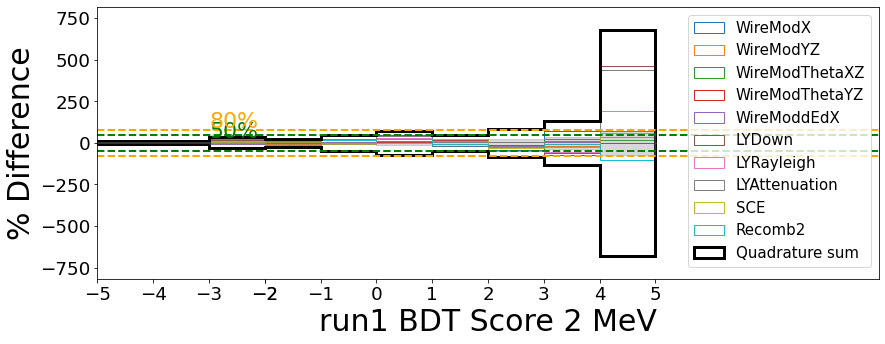

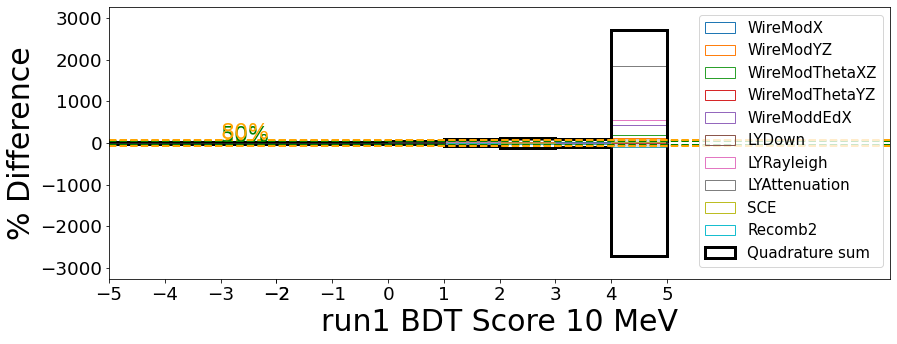

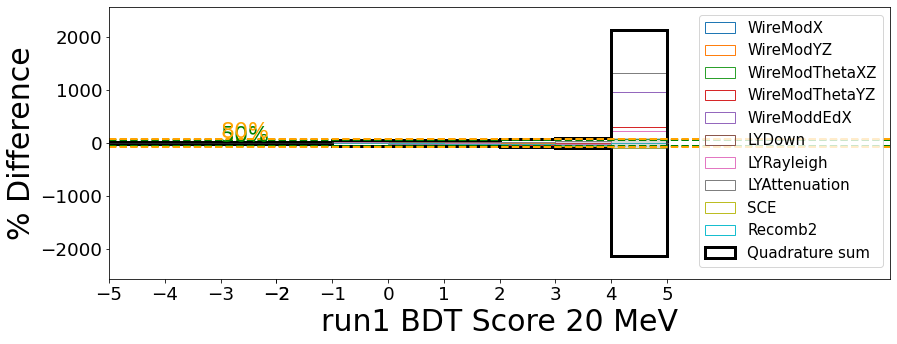

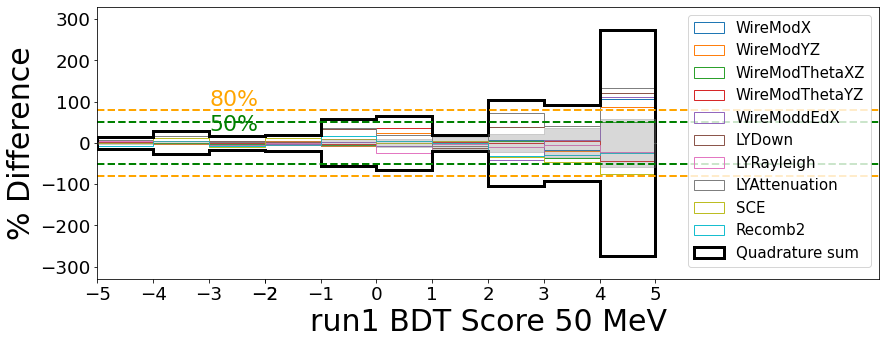

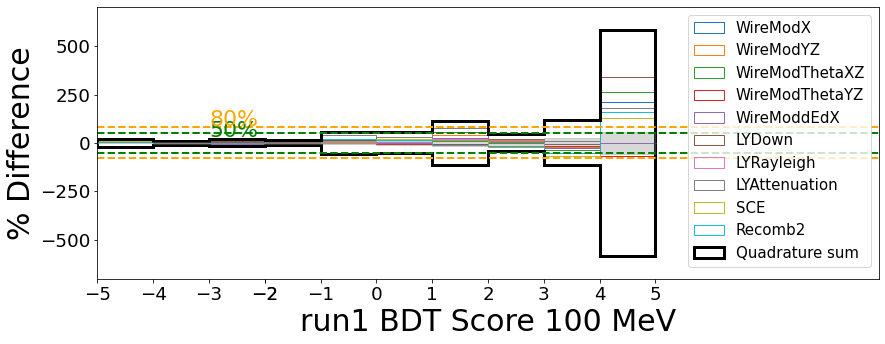

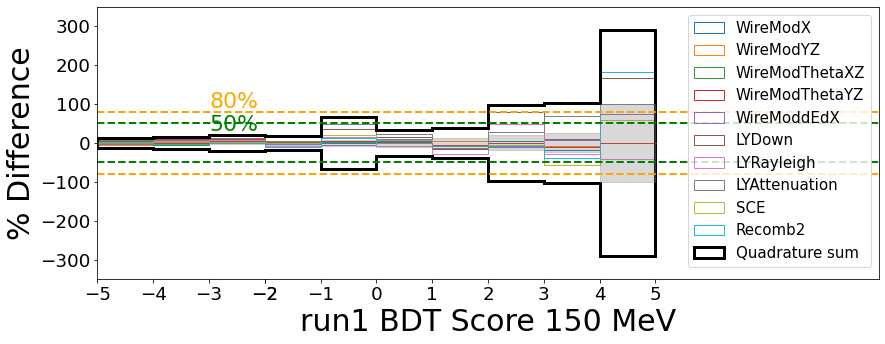

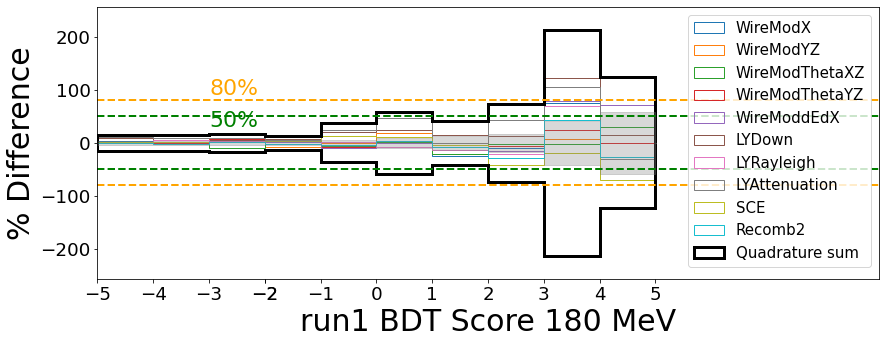

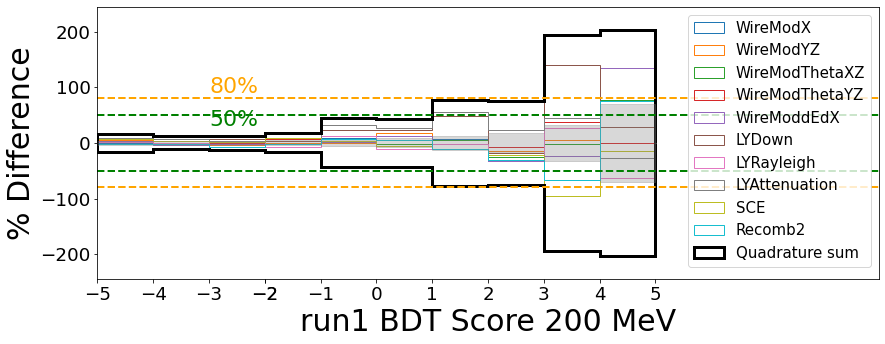

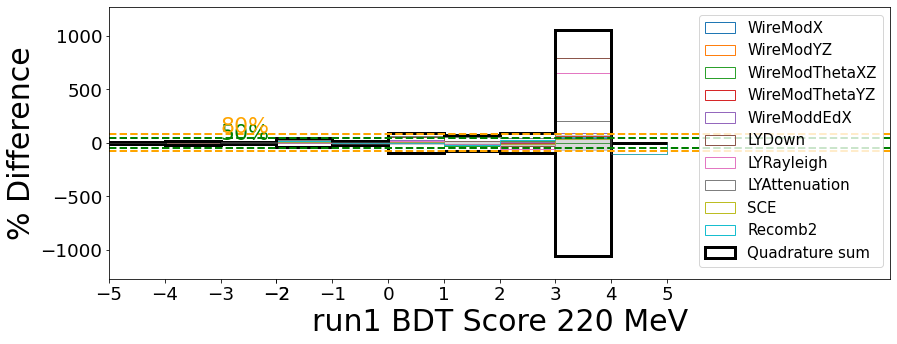

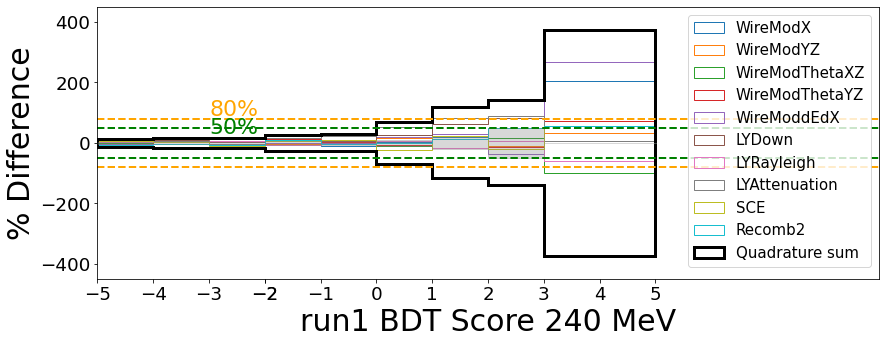

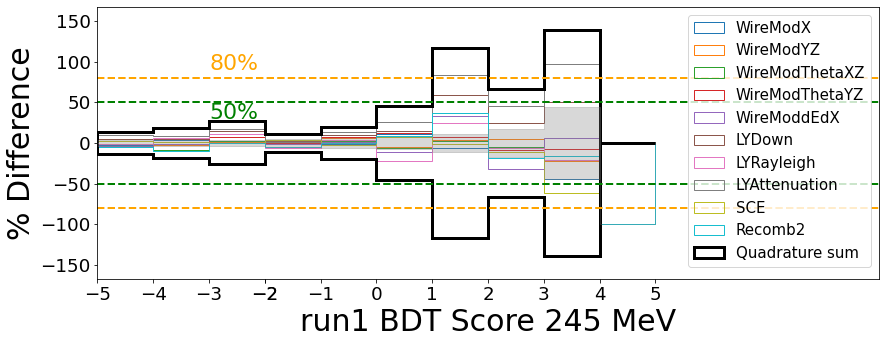

In [84]:
DetVar_percentages_dict = {}
savefig = False
display = True

figsize=(14, 5)
linewidth = 1
h_line_1 = 50 #Line displaying this % difference
h_line_2 = 80

for HNL_mass in Constants.HNL_mass_samples: #Looping over all mass points
    
    print(f"Plotting {HNL_mass}MeV histogram") 
    if Params["Use_logit"] == True:
        bins = bins_dict[HNL_mass]
        nbins = len(bins)-1
        xrange = [bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]]
        # xlims = [-0.5, 7]
        # xticks = [0, 1, 2, 3, 4, 5]
        xlims = [-5, 9]
        xticks = [-5, -4, -3, -2, -2, -1, 0, 1, 2, 3, 4, 5]
    else:
        bins = np.linspace(0,1, 21)
        nbins = len(bins)-1
        xrange = [bins[0], bins[-1]]
        xlims = [0,1.4]
        xticks = [0, 0.2, 0.4, 0.8, 1.0]
    
    plt.figure(figsize=figsize,facecolor='white')
    quad_sum=np.zeros(nbins)
    frac_quad_sum=np.zeros(nbins)
    sum_squares = np.zeros(nbins)
    stat_err = np.zeros(nbins)
    SF_on_bin = np.zeros(nbins)
    upvals = np.zeros(nbins+1)
    lowvals = np.zeros(nbins+1)
    upvals_frac = np.zeros(nbins+1)
    lowvals_frac = np.zeros(nbins+1)
    x_coords = bins_dict[HNL_mass]
    max_y = 0
    
    if Params["Use_logit"] == False:
        cv_hist, cv_bins = np.histogram(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV'],
        range=xrange,
        bins=nbins,
        weights=sample_test_dict["CV"]["weight"])
    if Params["Use_logit"] == True:
        cv_hist, cv_bins = np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']),
        range=xrange,
        bins=bins,
        weights=sample_test_dict["CV"]["weight"])
    bins_cent=(cv_bins[:-1]+cv_bins[1:])/2
    for DetVar in Constants.Detector_variations:
        if DetVar == "CV":
            continue
        perc_list = []
        if Params["Use_logit"] == False:
            detvar_hist, bins = np.histogram(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV'],
            range=xrange,
            bins=nbins,
            weights=sample_test_dict[DetVar]["weight"])
        if Params["Use_logit"] == True:
            detvar_hist, bins = np.histogram(Functions.logit(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV']),
            range=xrange,
            bins=bins,
            weights=sample_test_dict[DetVar]["weight"])
        for i in range(len(detvar_hist)):
            frac = safe_div(detvar_hist[i],cv_hist[i])
            frac_diff = frac - 1.0
            perc_list.append(frac_diff*100)
            
        # quad_sum=quad_sum+np.array(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV']**2) #Is there a way to do it in this loop?
        
        DetVar_percentages_dict[DetVar] = perc_list
        plt.hist(bins_cent,weights=DetVar_percentages_dict[DetVar], bins=bins,range=xrange,label=f'{DetVar}',
                lw=linewidth,histtype="step") #just 1 entry for each bin, then "weight" becomes what the percentage is (hacky way, could do something nicer)
        
    cv_no_weighting = np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']),
        range=xrange,
        bins=nbins)[0]
    
    for j in range(len(cv_hist)):
        for DetVar in Constants.Detector_variations:
            if DetVar == "CV":
                continue
            if Params["Use_logit"] == False:
                hist_input = sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV']
            if Params["Use_logit"] == True:
                hist_input = Functions.logit(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV'])
                    
            detvar_hist, bins = np.histogram(hist_input,
            range=xrange, #Need to change to full range
            bins=bins, #Need to change to full range
            weights=sample_test_dict[DetVar]["weight"])
            
            diff = cv_hist[j] - detvar_hist[j]
            diff_squared = diff**2
            sum_squares[j] = sum_squares[j]+diff_squared
            
            # SF_on_bin[j] = cv_hist[j]/cv_no_weighting[j] #This effective scale factor comes in by weighting on events
            SF_on_bin[j] = safe_div(cv_hist[j],cv_no_weighting[j])
            stat_err[j] = np.sqrt(cv_no_weighting[j])*SF_on_bin[j]
            upvals[j] = cv_hist[j]+stat_err[j]
            lowvals[j] = cv_hist[j]-stat_err[j]
            upvals_frac[j] = safe_div(upvals[j],cv_hist[j])*100-100
            lowvals_frac[j] = safe_div(lowvals[j],cv_hist[j])*100-100
            
        quad_sum[j] = np.sqrt(sum_squares[j])
        frac_quad_sum[j] = safe_div(quad_sum[j],cv_hist[j])#quad_sum[j]/cv_hist[j]
    max_y = max(frac_quad_sum)
    # print(max_y)
    ylims = [max_y*(-1.2)*100, max_y*(1.2)*100]
    plt.hist(bins_cent, weights=frac_quad_sum*100, bins=bins,range=xrange,label=f'Quadrature sum',lw=linewidth+2,
             histtype="step", color="black")
    plt.hist(bins_cent, weights=frac_quad_sum*(-100), bins=bins,range=xrange,lw=linewidth+2,
             histtype="step", color="black")

    plt.fill_between(x_coords, lowvals_frac, upvals_frac, step="post",color="grey",alpha=0.3,zorder=2)
    
    plt.legend(loc='upper right',frameon=True)
    plt.ylim(ylims)
    plt.xlim(xlims) #Goes up to 7 to leave space for the legend
    # plt.xlim([-5, 9]) #Goes up to 7 to leave space for the legend
    plt.xlabel(Params["Run"] + f' BDT Score {HNL_mass} MeV', fontsize=30)
    plt.ylabel('% Difference', fontsize=30)
    
    plt.axhline(y=h_line_1, lw=2, color='green', linestyle = 'dashed')
    plt.axhline(y=-1*(h_line_1), lw=2, color='green', linestyle = 'dashed')
    plt.text(-3, 30, "50%", color='green')
    
    plt.axhline(y=h_line_2, lw=2, color='orange', linestyle = 'dashed')
    plt.axhline(y=-1*(h_line_2), lw=2, color='orange', linestyle = 'dashed')
    plt.text(-3, 90, "80%", color='orange')
    
    plt.xticks(xticks) #Only keeping values for BDT scores which are possible.
    # plt.xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]) #Only keeping values for BDT scores which are possible.
    #plt.yscale()
    if savefig == True:
        plt.savefig("plots/Sys_uncertainty/Overlay/DetVar/" + Params["Run"] + "_" + str(HNL_mass) + "_MeV_DetVars_lines.png")
    if display == False:
            plt.close()

In [57]:
print(upvals)

nan


In [59]:
#Owen's way of getting lines of detvariations
lims=np.linspace(-5,5,40)
plt.plot(lims,sample_info_dets[sys]["BDTprox"],label=dectsysname[sys])
for lim in lims:
    for lim in lims:
        n_var=len(sample_info_dets[sys]["vert_df"].query(query+f" & results_nu_{HNL_mass_key}>{lim}").drop_duplicates(subset=["run","sub","evt"]))

SyntaxError: unexpected EOF while parsing (1589999871.py, line 4)

# End of code